# Importing required libs

In [ ]:
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler , TensorBoard , EarlyStopping
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras import backend as K
import os
import datetime
import numpy as np
import shutil
# from skimage import morphology, feature, segmentation, measure, io, color
# from skimage.filters import sobel
import matplotlib.pyplot as plt
import pdb
import imageio
from scipy import misc
import scipy.ndimage as ndimage
import cv2
from skimage import io, filters, morphology, measure, feature, color
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import pandas as pd
from scipy.ndimage import gaussian_filter, label
from skimage.feature import peak_local_max


# import warnings
# warnings.filterwarnings('ignore')
# warnings.filterwarnings("ignore", category=UserWarning, module="imageio")
# from google.colab.patches import cv2_imshow  # Only required in Google Colab


In [1]:

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# List available physical devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:")
for device in physical_devices:
    print(device)

# Check if TensorFlow is using the GPU
if tf.test.is_built_with_cuda():
    print("TensorFlow is built with CUDA")
    if len(physical_devices) > 0:
        print("TensorFlow is using the GPU")
    else:
        print("TensorFlow is not using the GPU, but it is available")
else:
    print("TensorFlow is not built with CUDA")


TensorFlow version: 2.6.0
Available GPUs:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow is built with CUDA
TensorFlow is using the GPU


In [2]:
%run generator.ipynb
%run model.ipynb

## test GPU for a simple training

In [4]:
# # Add these at the start of your code
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # 0=all, 1=no info, 2=no warnings, 3=no errors
# tf.keras.backend.clear_session()  # Reset any existing graphs

In [5]:
# import numpy as np
# import tensorflow as tf
#
# # Synthetic data test
# X = np.random.rand(100, 256, 256, 1)
# y = np.random.rand(100, 1)
#
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(8, 3, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(1)
# ])
#
# model.compile('adam', 'mse')
#
# # Force CPU-only mode to test
# with tf.device('/GPU:0'):
#     model.fit(X, y, batch_size=4, epochs=100)
# # model.fit(X, y, batch_size=4, epochs=2)  # Should run immediately

# Visualization methods

In [4]:
image_height = 256
image_width = 256
def load_input_labels_images(input_image_folder , gt_image_folder , regions_image_folder , factor= 100):
    images = []
    gt_labels = []
    regions_labels = []
    dots_count=[]
    file_names=[]
    downsamplede_dots_count=[]
    for filename in os.listdir(input_image_folder):
        img_path = os.path.join(input_image_folder, filename)
        gt_label_path = os.path.join(gt_image_folder, filename)
        regions_label_path = os.path.join(regions_image_folder, filename)
        # Skip if it's a directory
        if os.path.isdir(img_path):
            continue
        print( img_path)
        # print( gt_label_path)
        # print( regions_label_path)
        
        file_names.append(filename)
        img = cv2.imread(img_path)  # Read as grayscale
        resized_img = cv2.resize(img, (image_height, image_width))
        
        gt_label_image = cv2.imread( gt_label_path )
        # resized_gt_label_image = cv2.resize(gt_label_image, (image_height, image_width))
        
        regions_label_image = cv2.imread( regions_label_path )
        # resized_regions_label_image = cv2.resize(regions_label_image, (image_height, image_width))


        gt_density_map = io.imread( gt_label_path , as_gray=True)
        # resized_gt_label_image = cv2.resize(gt_density_map, (image_height, image_width))

        
        # plt.imshow(gt_label_image)
        # plt.axis('off')  # Turn off axis numbers and ticks
        # plt.show() 

        gt_cell_centroids = detect_cells(gt_density_map, sigma=2, threshold_factor=1.5)
        # resized_cell_centroids = detect_cells(resized_gt_label_image, sigma=2, threshold_factor=1.5)

        gt_label_image= factor * (gt_label_image> 0)
        gt_label_image = np.expand_dims(gt_label_image, axis=-1)
        

        # resized_gt_label_image= factor * (resized_gt_label_image > 0)
        # resized_gt_label_image = np.expand_dims(resized_gt_label_image, axis=-1)

       
        # print(gt_label_image.shape , resized_gt_label_image.shape)  # Output: (256, 256, 1)
        # print(np.unique(gt_label_image) , np.unique(resized_gt_label_image))
        # print(len(gt_cell_centroids), len(resized_cell_centroids))
        # print(len(gt_cell_centroids))

        dots_count.append(len(gt_cell_centroids))
        # downsamplede_dots_count.append(len(resized_cell_centroids))

       
        
        if img is not None and gt_label_image is not None and regions_label_image is not None :
            # print(img.shape , np.unique(gt_label_image) , regions_label_image.shape )
            images.append(img)
            gt_labels.append(gt_label_image)
            regions_labels.append(regions_label_image)
    # return np.array(images), np.array(gt_labels) , np.array(regions_labels), np.array(dots_count) , np.array(downsamplede_dots_count) , np.array(file_names)
    return np.array(images), np.array(gt_labels) , np.array(regions_labels), np.array(dots_count)  , np.array(file_names)

In [5]:
def to_three_channels(img):
  return np.squeeze(np.stack((img,img,img), 2))

def show_sample(img, anno, label):
  squeezed =  np.squeeze(anno)

  figure, axis = plt.subplots(1,3)
  axis[0].imshow(img)
  axis[1].imshow(squeezed)
  squeezed =  np.squeeze(label)
  axis[2].imshow(squeezed)




def show_batch(img, label):
  show_sample(img[0,:,:,:],label[0,:,:,:])

In [6]:
def save_sample(img, label , gt,  folder_name , sample_file_name, lable_type , counts):
    folder_name = folder_name + str(sample_file_name).split("dic.png")[0] + "/"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(folder_name)
        output_path = os.path.join(folder_name, 'counts.txt')
        with open(output_path, 'w') as file:
            file.write(str(counts) + '\n')


    squeezed_label =  np.squeeze(label)
    squeezed_gt =  np.squeeze(gt)


    # Ensure images are in the correct range
    if img.dtype == np.float64 or img.dtype == np.float32:
        img = np.interp(img, (img.min(), img.max()), (0, 1))

    if squeezed_label.dtype == np.float64 or squeezed_label.dtype == np.float32:
        squeezed_label = np.interp(squeezed_label, (squeezed_label.min(), squeezed_label.max()), (0, 1))
    if squeezed_gt.dtype == np.float64 or squeezed_gt.dtype == np.float32:
        squeezed_gt = np.interp(squeezed_gt, (squeezed_gt.min(), squeezed_gt.max()), (0, 1))


    # Save the first image
    fig, ax = plt.subplots()
    ax.imshow(img)
    # ax.set_title('Image')
    plt.axis('off')  # Turn off the axis
    output_path = os.path.join(folder_name, 'image_1.jpg')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)  # Save without white spaces
    plt.close(fig)  # Close the figure to free up memory


    # Save the third image
    fig, ax = plt.subplots()
    ax.imshow(squeezed_label)
    # ax.set_title('Squeezed Label')
    plt.axis('off')  # Turn off the axis
    output_path = os.path.join(folder_name, 'image_pr_'+lable_type+'.jpg')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)  # Save without white spaces
    plt.close(fig)  # Close the figure to free up memory

     # Save the third image
    fig, ax = plt.subplots()
    ax.imshow(squeezed_gt)
    # ax.set_title('Squeezed gt')
    plt.axis('off')  # Turn off the axis
    output_path = os.path.join(folder_name, 'image_gt_'+lable_type+'.jpg')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)  # Save without white spaces
    plt.close(fig)  # Close the figure to free up memory
    # plt.show()


def show_save_all_sample(img , c_label , c_gt , r_label , r_gt , folder_name , sample_file_name , counts ):

    squeezed_r_label = np.squeeze(r_label)
    squeezed_c_label = np.squeeze(c_label)
    # Ensure images are in the correct range
    if img.dtype == np.float64 or img.dtype == np.float32:
        img = np.interp(img, (img.min(), img.max()), (0, 1))

    if squeezed_c_label.dtype == np.float64 or squeezed_c_label.dtype == np.float32:
        squeezed_c_label = np.interp(squeezed_c_label, (squeezed_c_label.min(), squeezed_c_label.max()), (0, 1))


    if squeezed_r_label.dtype == np.float64 or squeezed_c_label.dtype == np.float32:
        squeezed_r_label = np.interp(squeezed_r_label, (squeezed_r_label.min(), squeezed_r_label.max()), (0, 1))


    figure, axis = plt.subplots(1, 5, figsize=(15, 5))
    axis[0].imshow(img)
    axis[0].set_title('Image')
    axis[0].axis('off')


    axis[1].imshow(c_gt)
    axis[1].set_title('Centroids Ground Truth')
    axis[1].axis('off')

    axis[2].imshow(squeezed_c_label)
    axis[2].set_title('Centroids Prediction')
    axis[2].axis('off')



    axis[3].imshow(r_gt)
    axis[3].set_title('Regions Ground Truth')
    axis[3].axis('off')

    axis[4].imshow(squeezed_r_label)
    axis[4].set_title('Regions Prediction')
    axis[4].axis('off')

    plt.show()
    save_sample(img, c_label ,c_gt, folder_name , sample_file_name, "centroids" , counts)
    save_sample(img, r_label ,r_gt, folder_name , sample_file_name, "regions" , counts )




In [7]:
def detect_cells(density_map, sigma=2, threshold_factor=1.5):
    """
    Detect cells using local maxima detection on a smoothed density map.

    Parameters:
        density_map (numpy.ndarray): Input density map (2D array).
        sigma (float): Standard deviation for Gaussian smoothing.
        threshold_factor (float): Factor to determine threshold for local maxima based on mean and std.

    Returns:
        cell_centroids (list of tuples): List of detected cell centroids as (x, y) coordinates.
    """
    # Smooth the density map using a Gaussian filter
    smoothed_map = gaussian_filter(density_map, sigma=sigma)

    # Calculate threshold based on the mean and standard deviation of the smoothed map
    mean_val = np.mean(smoothed_map)
    std_val = np.std(smoothed_map)
    threshold = mean_val + threshold_factor * std_val
    # Identify local maxima above the threshold
    coordinates = peak_local_max(smoothed_map, min_distance=2, threshold_abs=threshold)

    # Convert to a list of (x, y) tuples
    cell_centroids = [(int(x), int(y)) for y, x in coordinates]

    return cell_centroids



# load data -tqdm

In [10]:
# import os
# import cv2
# import numpy as np
# from skimage import io
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor, as_completed
#
#
# image_height = 256
# image_width = 256
#
# def process_single_file(args):
#     filename, input_image_folder, gt_image_folder, regions_image_folder, factor = args
#
#     img_path = os.path.join(input_image_folder, filename)
#     if os.path.isdir(img_path):
#         return None  # Skip directories
#
#     gt_label_path = os.path.join(gt_image_folder, filename)
#     regions_label_path = os.path.join(regions_image_folder, filename)
#
#     img = cv2.imread(img_path)
#     if img is None:
#         print(f"Warning: Failed to read image {img_path}")
#         return None
#
#     try:
#         resized_img = cv2.resize(img, (image_height, image_width))
#
#         gt_label_image = cv2.imread(gt_label_path)
#         regions_label_image = cv2.imread(regions_label_path)
#         if gt_label_image is None or regions_label_image is None:
#             print(f"Warning: Missing label for {filename}, skipping.")
#             return None
#
#         gt_density_map = io.imread(gt_label_path, as_gray=True)
#         gt_cell_centroids = detect_cells(gt_density_map, sigma=2, threshold_factor=1.5)
#
#         gt_label_image = factor * (gt_label_image > 0)
#         gt_label_image = np.expand_dims(gt_label_image, axis=-1)
#
#         return resized_img, gt_label_image, regions_label_image, len(gt_cell_centroids), filename
#
#     except Exception as e:
#         print(f"Error processing {filename}: {e}")
#         return None
#
#
# def load_input_labels_images(input_image_folder, gt_image_folder, regions_image_folder, factor=100, max_workers=8):
#     images = []
#     gt_labels = []
#     regions_labels = []
#     dots_count = []
#     file_names = []
#
#     all_filenames = os.listdir(input_image_folder)
#     args_list = [(filename, input_image_folder, gt_image_folder, regions_image_folder, factor)
#                  for filename in all_filenames]
#
#     with ThreadPoolExecutor(max_workers=max_workers) as executor:
#         futures = [executor.submit(process_single_file, args) for args in args_list]
#         for future in tqdm(as_completed(futures), total=len(futures), desc="Loading images (parallel)"):
#             result = future.result()
#             if result is not None:
#                 img, gt_label_img, region_label_img, dot_count, fname = result
#                 images.append(img)
#                 gt_labels.append(gt_label_img)
#                 regions_labels.append(region_label_img)
#                 dots_count.append(dot_count)
#                 file_names.append(fname)
#
#     return (
#         np.array(images),
#         np.array(gt_labels),
#         np.array(regions_labels),
#         np.array(dots_count),
#         np.array(file_names)
#     )


In [11]:
# base_address= './Dataset/'
# input_image_folder = base_address+'train/dic_tiles/'
# gt_image_folder = base_address +'train/gt_tiles/'
# regions_image_folder =base_address +'train/regions_tiles/'
#
# # data, anno_centroids , anno_regions, cell_auto_counts , cell_auto_counts_downsampled , file_names = load_input_labels_images(input_image_folder, gt_image_folder , regions_image_folder  )
# data, anno_centroids , anno_regions, cell_auto_counts  , file_names = load_input_labels_images(input_image_folder, gt_image_folder , regions_image_folder  )
#
# print(f'Loaded {len(data)} cell images and  {len(anno_centroids)} gt label images and {len(anno_regions)} regions label images and {len(file_names)}  file names. ')

In [12]:
# base_address= '../datasets/'
# input_image_folder = base_address+'test/dic_tiles/'
# gt_image_folder = base_address +'test/gt_tiles/'
# regions_image_folder =base_address +'test/regions_tiles/'
#
# # data, anno_centroids , anno_regions, cell_auto_counts , cell_auto_counts_downsampled , file_names = load_input_labels_images(input_image_folder, gt_image_folder , regions_image_folder  )
# val_data, val_anno_centroids , val_anno_regions, val_cell_auto_counts  , val_file_names = load_input_labels_images(input_image_folder, gt_image_folder , regions_image_folder  )
#
# print(f'Loaded {len(val_data)} cell images and  {len(val_anno_centroids)} gt label images and {len(val_anno_regions)} regions label images and {len(val_file_names)}  file names. ')

In [13]:
# print(f'Loaded {(data).shape} cell images and  {(anno_centroids).shape} gt label images and {(anno_regions).shape} regions label images and {(file_names).shape}  file names. ')

In [14]:

# Assume img.shape == (256, 256, 3, 1)
# img22 = np.squeeze(anno_centroids[0])  # Now shape is (256, 256, 3)

# plt.imshow(img22)
# plt.axis('off')
# plt.show()


In [15]:
# plt.imshow(anno_regions[0])
# plt.axis('off')  # Turn off axis numbers and ticks
# plt.show()

In [16]:
# data.shape , anno_centroids.shape , anno_regions.shape , cell_auto_counts_downsampled.shape , cell_auto_counts.shape , file_names

In [17]:
# cell_auto_counts , cell_auto_counts_downsampled

# Generating DIC like images

In [8]:
# base_address= './Dataset/'

In [19]:
# orig_address=['/train/orig/', '/test/orig/', '/eval/orig/']
# dic_address= ['/train/dic/', '/test/dic/', '/eval/dic/']
# for i in range(3):
#
#     folder_path = base_address + orig_address[i]
#     output_folder_path = base_address+ dic_address[i]
#
#     files = os.listdir(folder_path)
#     if not os.path.exists(output_folder_path):
#         os.makedirs(output_folder_path)
#
#     for file in files:
#         # Create the full file path
#         print(os.path.join(folder_path, file))
#         if 'ipynb_checkpoints' not in os.path.join(folder_path, file) :
#
#             file_path = os.path.join(folder_path, file)
#             # Load the input image
#             input_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
#
#             # Apply gradient filter to find edges of the cells
#             gradient_x = cv2.Sobel(input_image, cv2.CV_64F, 1, 0, ksize=3)
#             gradient_y = cv2.Sobel(input_image, cv2.CV_64F, 0, 1, ksize=3)
#             gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)
#
#             # Normalize gradient magnitude to [0, 255]
#             gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)
#
#             # Simulate shading
#             shading_strength = 0.5 # Adjust this parameter to control shading strength
#             shading = np.ones_like(input_image, dtype=np.float64) * 127
#             shading += shading_strength * gradient_magnitude
#
#             # Add shading to the input image
#             output_image = cv2.add(input_image, shading.astype(np.uint8))
#
#             new_file_name = file.replace('cell.png', '_dic.png')
#
#             output_file_path = os.path.join(output_folder_path, new_file_name)
#             print(output_file_path)
#             cv2.imwrite(output_file_path, output_image)

# Generating regions images

In [10]:
# def show_maped_centroids(centroids_path , regions_path):
#   imList = os.listdir(centroids_path)
#   for i in range(len(imList)):
#           # read the original image
#           if not os.path.exists(output_folder_path):
#             os.makedirs(output_folder_path)
#           binary_image = cv2.imread( os.path.join(centroids_path, imList[i]) , cv2.IMREAD_GRAYSCALE)
#           print(binary_image.shape)
#           image_height= binary_image.shape[0]
#           image_width=  binary_image.shape[1]
#           black_image = np.zeros((image_height, image_width, 1), dtype=np.uint8)
#
#           white_pixel_locations = np.where(binary_image >0)
#
#           for y, x in zip(*white_pixel_locations):
#               cv2.circle(black_image, (x, y), 25 , 255, -1)  # Draw a red circle at each white pixel location
#               cv2.circle(binary_image, (x, y), 25 , 255, -1)  # Draw a red circle at each white pixel location
#
#           # Show the result image
#           # cv2_imshow(black_image)
#           # cv2_imshow(binary_image)
#           cv2.imwrite( regions_path+ imList[i] + '.png'  , black_image )
#
#           print(str(os.path.join(centroids_path, imList[i])) , "\n\n\n"  )
#
# orig_address=['/train/gt/', '/test/gt/']
# dic_address= ['/train/regions/', '/test/regions/']
# for i in range(2):
#     data = []
#     anno = []
#     img_labels=[]
#
#     folder_path = base_address + orig_address[i]
#     output_folder_path = base_address+ dic_address[i]
#     show_maped_centroids(folder_path ,  output_folder_path )

(1400, 1400)
C:/Users/narges/PycharmProjects3/pythonProject3/Compelet_dataset_preprocessing/datasets//train/gt/10ld1.png 



(1400, 1400)
C:/Users/narges/PycharmProjects3/pythonProject3/Compelet_dataset_preprocessing/datasets//train/gt/10ld3.png 



(1400, 1400)
C:/Users/narges/PycharmProjects3/pythonProject3/Compelet_dataset_preprocessing/datasets//train/gt/10ll1.png 



(1400, 1400)
C:/Users/narges/PycharmProjects3/pythonProject3/Compelet_dataset_preprocessing/datasets//train/gt/10lr2.png 



(1400, 1400)
C:/Users/narges/PycharmProjects3/pythonProject3/Compelet_dataset_preprocessing/datasets//train/gt/10lr3.png 



(1400, 1400)
C:/Users/narges/PycharmProjects3/pythonProject3/Compelet_dataset_preprocessing/datasets//train/gt/10lu1.png 



(1400, 1400)
C:/Users/narges/PycharmProjects3/pythonProject3/Compelet_dataset_preprocessing/datasets//train/gt/10lu2.png 



(1400, 1400)
C:/Users/narges/PycharmProjects3/pythonProject3/Compelet_dataset_preprocessing/datasets//train/gt/10lu3.png 





# Data generator

In [8]:
import os
import numpy as np
import tensorflow as tf
from skimage import io, color
import re
from skimage.transform import resize


class CustomDataGenerator(tf.keras.utils.Sequence):

    def extract_main_name(self ,filename):
        parts = filename.split('_')
        for i, part in enumerate(parts):
            if re.fullmatch(r'\d{3}', part):  # Find the first 3-digit part
                return '_'.join(parts[:i])    # Main name is everything before that
        return None  # If no tile index found

    def main_name_ends_with_1(self , filename):
        main_name = self.extract_main_name(filename)
        return main_name is not None and main_name.endswith('1')

    def __init__(self, data_dir, label_dir, batch_size, dim, data_files=None, label_files=None , n_channels=1,
                 n_classes_or_output_dim=1 , shuffle=True, augmentor=None ):
        'Initialization'
        self.dim = dim  # e.g., (256, 256)
        self.batch_size = batch_size
        self.n_channels = n_channels  # Will be 1 for grayscale
        self.n_classes_or_output_dim = n_classes_or_output_dim  # e.g., 1 for regression output
        self.shuffle = shuffle
        self.augmentor = augmentor  # Your ImageDataGenerator instance
        self.target_size=self.dim[0]


        if data_files is None and label_files is None:
            self.data_dir = data_dir  # Directory containing input images
            self.label_dir = label_dir  # Directory containing label images
            self.filtered_filenames = sorted([
                f for f in os.listdir(data_dir)
                if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')) #and self.main_name_ends_with_1(f)
            ])
            self.data_files = [os.path.join(data_dir, f) for f in self.filtered_filenames]
            self.label_files = [os.path.join(label_dir, f) for f in self.filtered_filenames]
            # print("label files;",self.label_files[:5])
        else:
            self.data_files = data_files
            self.label_files = label_files

        # Get list of all image files in the directories
        # self.data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir)
        #                         if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])
        # self.label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir)
        #                          if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])

        # Verify that we have matching pairs of data and label files
        assert len(self.data_files) == len(self.label_files), "Number of input and label images must match"

        self.indexes = np.arange(len(self.data_files))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        try:
            # Calculate safe indexes
            start_idx = index * self.batch_size
            end_idx = min((index + 1) * self.batch_size, len(self.indexes))
            batch_indexes = self.indexes[start_idx:end_idx]

            # Ensure we don't return empty batches
            if len(batch_indexes) == 0:
                batch_indexes = self.indexes[-self.batch_size:]  # Take last complete batch

            X, y = self.__data_generation(batch_indexes)

            if self.augmentor:
                # augmented_X = np.empty_like(X)
                # augmented_y = np.empty_like(y)

                batch_iter = self.augmentor.flow(X.astype('float32'),
                                  y,
                                  batch_size = self.batch_size,
                                  shuffle=False
                                  )
                # img_aug = self.augmentor.standardize(img_aug)
                img_aug , lbl_aug = next(batch_iter)
                # augmented_X = img_aug
                # augmented_y = lbl_aug
                # print(img_aug.shape , lbl_aug.shape )
                return img_aug, lbl_aug
            else:
                # print('batch returned')
                return X, y
        except Exception as e:
            raise

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __data_generation(self, batch_indexes):
        X = np.empty((len(batch_indexes), *self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((len(batch_indexes), *self.dim, 1), dtype=np.float32)  # Single channel output
        for i, idx in enumerate(batch_indexes):
            # Load and process input image
            img = cv2.imread(self.data_files[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            lbl = cv2.imread(self.label_files[idx])
            lbl = cv2.cvtColor(lbl, cv2.COLOR_BGR2GRAY)
            # print('img index: ', idx , ' image shape: ', img.shape , lbl.shape)
            # print('img values: ',np.min(img), np.max(img ))

            height, width = img.shape[:2]
            # print(lbl.shape)
            # print(self.dim)
            if (height, width) != (self.dim[0] , self.dim[1]):
                pad_top = (self.target_size - height) // 2
                pad_bottom = self.target_size - height - pad_top
                pad_left = (self.target_size - width) // 2
                pad_right = self.target_size - width - pad_left

                img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)
                lbl = cv2.copyMakeBorder(lbl, pad_top, pad_bottom, pad_left, pad_right,  borderType=cv2.BORDER_CONSTANT, value=0)
            # Process labels
            img =img[:, :, np.newaxis]
            lbl = lbl[:, :, np.newaxis]
            # print('lable  values: ' ,np.min(lbl), np.max(lbl) , ' uniq vals: ', np.unique(lbl))

            X[i,] = img
            y[i,] = lbl


        return  X,y

### test data generator

train batch length:  6633 test batch length:  1404
train_gen data shape:  (4, 256, 256, 1) (4, 256, 256, 1) label img min, mean, max :  0.0 27.777786 255.0
test_gen data shape:  (4, 256, 256, 1) (4, 256, 256, 1) label min, mean, max :  0.0 76.3568115234375 255.0


C:\Users\narges\AppData\Local\Temp\ipykernel_45088\2908956172.py:5: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,


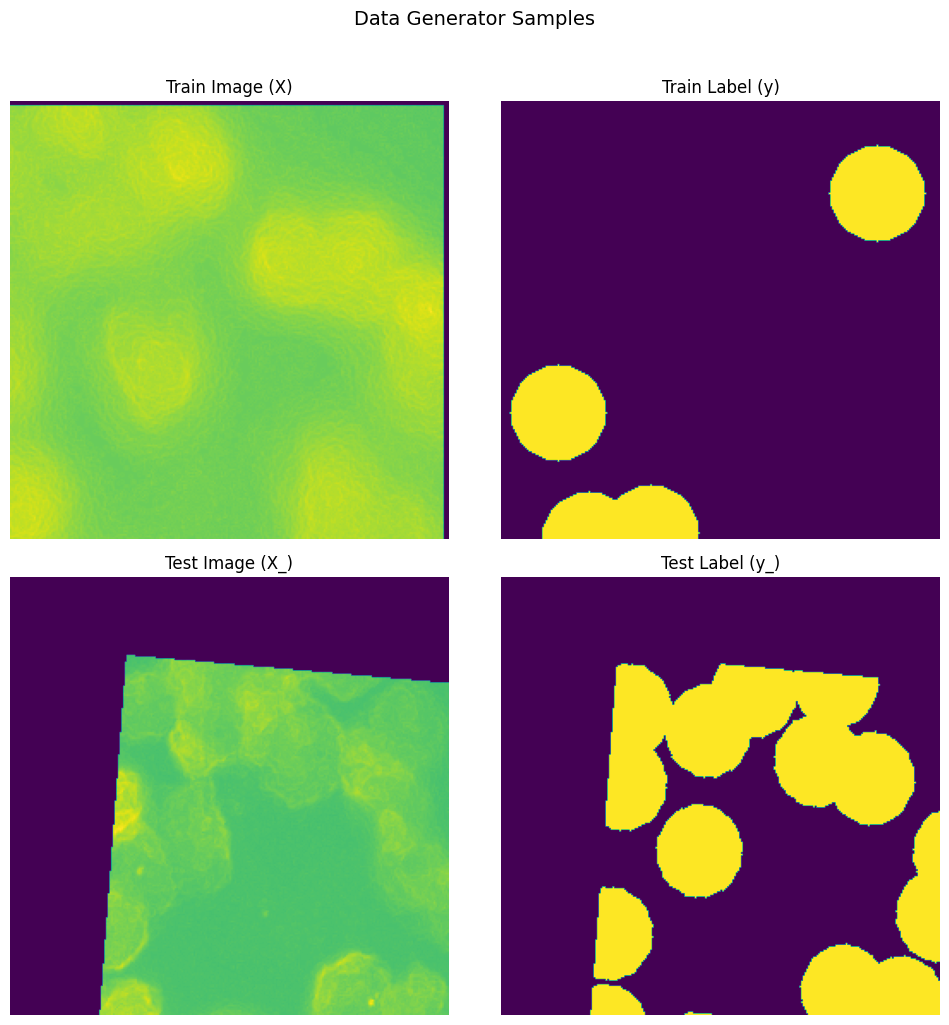

In [9]:
base_address= './Dataset/'
train_img_path = base_address + 'train/dic_tiles_256/'
train_centroids_img_path = base_address + 'train/regions_tiles/'

test_img_path = base_address + 'test/dic_tiles_256/'
test_centroids_img_path = base_address + 'test/regions_tiles/'
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
        zoom_range = 0.3,
        shear_range = 0.,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True, # randomly flip images
        fill_mode = 'constant',
        dim_ordering = 'tf')
train_generator = CustomDataGenerator(
    data_dir=train_img_path,
    label_dir=train_centroids_img_path,
    batch_size=4,
    dim=(256, 256),  # Target size
    data_files=None,
    label_files=None ,
    n_channels=1,     # Grayscale
    shuffle=True,
    augmentor=None  # Optional
)
test_generator = CustomDataGenerator(
    data_dir=test_img_path,
    label_dir=test_centroids_img_path,
    batch_size=4,
    dim=(256, 256),  # Target size
    data_files=None,
    label_files=None ,
    n_channels=1,     # Grayscale
    shuffle=True,
    augmentor=datagen  # Optional
)
print('train batch length: ' , len(train_generator) , 'test batch length: ' , len(test_generator))

for i in range(len(train_generator)):
    tr_X, tr_y  = train_generator[i]
    te_X_, te_y_  = test_generator[i]
    print('train_gen data shape: ' ,tr_X.shape , tr_y.shape , 'label img min, mean, max : ', np.min(tr_y[0]) , np.mean(tr_y[0]), np.max(tr_y[0]))
    print('test_gen data shape: ' ,te_X_.shape , te_y_.shape , 'label min, mean, max : ', np.min(te_y_[0]) , np.mean(te_y_[0]), np.max(te_y_[0]))
    # y = y.squeeze(-1)
    # squeezed_y =  np.squeeze(y)

    # print(squeezed_y.shape)

    # if y[i].ndim == 3:  # Check if 3D (H,W,3 or H,W,1)
    #         y[i] = np.mean(y[i], axis=-1)


    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot training samples
    axs[0, 0].imshow(tr_X[0])
    axs[0, 0].set_title('Train Image (X)')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(tr_y[0])
    axs[0, 1].set_title('Train Label (y)')
    axs[0, 1].axis('off')

    # Plot testing samples
    axs[1, 0].imshow(te_X_[0])
    axs[1, 0].set_title('Test Image (X_)')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(te_y_[0])
    axs[1, 1].set_title('Test Label (y_)')
    axs[1, 1].axis('off')

    plt.suptitle('Data Generator Samples', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
    break

# Light-U-Net Centroids

## Network Defenition

In [29]:

# tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

# def step_decay(epoch):
#     step = 16
#     lrate=1e0
#     num =  epoch // step
#     if num % 3 == 0:
#         lrate = 1e-3
#     elif num % 3 == 1:
#         lrate = 1e-4
#     else:
#         lrate = 1e-5
#         #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
#     print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
#     return float(lrate)


def step_decay(epoch):
    step = 3
    lrate=1e0
    num =  epoch // step
    if num % 3 == 0:
        lrate = 5e-1
    elif num % 3 == 1:
        lrate = 1e-2
    else:
        lrate = 1e-3
        #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
    return float(lrate)

np.float = float
def train_(train_img_path, train_anno_path , test_img_path, test_anno_path ):

    file_name=  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # print("train set size : ",len(train_data) , " test set size : " , len(val_data) )


    print('-'*30)
    print('Creating and compiling the fully convolutional regression networks.')
    print('-'*30)

    model = buildModel_Light_U_net(input_dim = (256,256,1))
    model_checkpoint = ModelCheckpoint('./checkpoints/light_U_Net_centroids_256_image'+file_name+'.hdf5', monitor='val_loss', save_best_only=True)
    early_stop = EarlyStopping(
        monitor='val_loss',       # ✅ Recommended
        patience=5,
        restore_best_weights=True
    )
    # change_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    model.summary()
    print('...Fitting model...')
    print('-'*30)
    change_lr = LearningRateScheduler(step_decay)
    batch_size = 16
    input_dim_hw = (256, 256) # Height, Width
    n_channels_img = 1

    # Create the ImageDataGenerator for augmentation parameters
    # datagen_params = ImageDataGenerator(
    #     rotation_range=30,
    #     width_shift_range=0.3,
    #     height_shift_range=0.3,
    #     zoom_range=0.3,
    #     shear_range=0.,
    #     horizontal_flip=True,
    #     vertical_flip=True,
    #     fill_mode='constant',
    #     dim_ordering='tf'
    #     # DO NOT include featurewise_center, samplewise_center etc. here
    #     # if you plan to standardize within the generator or as a preprocessing step.
    # )


    train_generator = CustomDataGenerator(
        data_dir=train_img_path,
        label_dir=train_anno_path,
        batch_size=batch_size,
        dim=input_dim_hw,  # Target size
        n_channels=n_channels_img,  # Grayscale
        shuffle=True,
        augmentor=None  # Optional
    )
    val_generator = CustomDataGenerator(
        data_dir=test_img_path,
        label_dir=test_anno_path,
        batch_size=batch_size,
        dim=input_dim_hw,  # Target size
        n_channels=n_channels_img,  # Grayscale
        shuffle=True,
        augmentor=None  # Optional
    )
    with tf.device('/GPU:0'):
        history = model.fit(train_generator, # Use model.fit with generators
                            validation_data=val_generator,
                            epochs=30,
                            # callbacks=[model_checkpoint, change_lr],
                            callbacks=[model_checkpoint, change_lr, early_stop],  # 👈 Add here
                            workers=8, # Number of worker threads for parallel data loading
                            verbose=1
                            # use_multiprocessing=True, # If True, use process-based threading
                            # max_queue_size=32
                           )
    return history , model

In [30]:
# import tensorflow as tf
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Allocate a small tensor to force memory initialization
#         tf.ones((1, 1)).numpy()  # Dummy operation to trigger GPU usage
#
#         # Get memory info (works in TF 2.4+)
#         memory_info = tf.config.experimental.get_memory_info('GPU:0')
#         print(f"GPU Memory - Current: {memory_info['current'] / (1024**2):.2f} MB")
#         print(f"GPU Memory - Peak   : {memory_info['peak'] / (1024**2):.2f} MB")
#     except KeyError:
#         print("Memory info not available. Use 'nvidia-smi' instead.")
# else:
#     print("No GPU detected. Running on CPU.")

In [31]:
# import tensorflow as tf
#
# # Ensure GPU is visible
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)  # Prevents TF from reserving all VRAM at once
# # Run your model and check peak usage
# print(tf.config.experimental.get_memory_info('GPU:0'))
# tf.keras.mixed_precision.set_global_policy('mixed_float16')  # Add before model creation


## Train Network

In [32]:
base_address = './Dataset/'
train_img_path = base_address + 'train/dic_tiles_256/'
train_centroids_img_path = base_address + 'train/gt_tiles_256/'

test_img_path = base_address + 'test/dic_tiles_256/'
test_centroids_img_path = base_address + 'test/gt_tiles_256/'


In [33]:
history_center , model_center = train_(train_img_path, train_centroids_img_path ,test_img_path, test_centroids_img_path )

------------------------------
Creating and compiling the fully convolutional regression networks.
------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 64) 576         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 256, 256, 64) 256         conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 256, 256, 64) 0       

## loss chart

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_center.history['loss'], label='Training Loss')
plt.plot(history_center[0].history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of Light-U-Net-Centroids')
plt.legend()
plt.show()

# Light-U-Net Regions

## Network Definition

In [10]:

# tf.config.run_functions_eagerly(True)

def step_decay(epoch):
    step = 3
    lrate=5e0
    num =  epoch // step
    if num % 3 == 0:
        lrate = 5e-1
    elif num % 3 == 1:
        lrate = 5e-2
    else:
        lrate = 5e-3
        #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    # print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
    return float(lrate)

np.float = float
def train_(train_img_path, train_anno_path , test_img_path, test_anno_path ):

    file_name=  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # print("train set size : ",len(train_data) , " test set size : " , len(val_data) )


    print('-'*30)
    print('Creating and compiling the fully convolutional regression networks.')
    print('-'*30)

    model = buildModel_Light_U_net(input_dim = (256,256,1))
    model_checkpoint = ModelCheckpoint('./checkpoints/Light_U_Net_regions_256_image'+file_name+'.hdf5', monitor='val_loss', save_best_only=True)
    early_stop = EarlyStopping(
            monitor='val_loss',       # ✅ Recommended
            patience=5,
            restore_best_weights=True
        )
    # change_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    model.summary()
    print('...Fitting model...')
    print('-'*30)
    change_lr = LearningRateScheduler(step_decay)
    batch_size = 8
    input_dim_hw = (256, 256) # Height, Width
    n_channels_img = 1


    datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
        zoom_range = 0.3,
        shear_range = 0.,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True, # randomly flip images
        fill_mode = 'constant',
        dim_ordering = 'tf')

    train_generator = CustomDataGenerator(
        data_dir=train_img_path,
        label_dir=train_anno_path,
        batch_size=batch_size,
        dim=input_dim_hw,  # Target size
        data_files=None,
        label_files=None ,
        n_channels=n_channels_img,  # Grayscale
        shuffle=True,
        augmentor=datagen  # Optional
    )
    test_generator = CustomDataGenerator(
        data_dir=test_img_path,
        label_dir=test_anno_path,
        batch_size=batch_size,
        dim=(256, 256),  # Target size
        data_files=None,
        label_files=None ,
        n_channels=1,     # Grayscale
        shuffle=True,
        augmentor=None  # Optional
    )
    with tf.device('/GPU:0'):
        history = model.fit(train_generator, # Use model.fit with generators
                            validation_data=test_generator,
                            epochs=30,
                            callbacks=[model_checkpoint, change_lr, early_stop],  # 👈 Add here
                            workers=8, # Number of worker threads for parallel data loading
                            # use_multiprocessing=True, # If True, use process-based threading
                            # max_queue_size=32
                           )
    return history , model

## Train Network

In [11]:
base_address = './Dataset/'
train_img_path = base_address + 'train/dic_tiles_256/'
train_regions_img_path = base_address + 'train/regions_tiles_2/'

test_img_path = base_address + 'test/dic_tiles_256/'
test_regions_img_path = base_address + 'test/regions_tiles_2/'


In [12]:
history_center , model_center = train_(train_img_path, train_regions_img_path ,test_img_path, test_regions_img_path)


------------------------------
Creating and compiling the fully convolutional regression networks.
------------------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0         

C:\Users\narges\AppData\Local\Temp\ipykernel_45088\2908956172.py:5: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,


Epoch 1/30
3317/3317 [==============================] - 235s 69ms/step - loss: 8707.2627 - val_loss: 11607.8789
Epoch 2/30
3317/3317 [==============================] - 224s 68ms/step - loss: 8365.3125 - val_loss: 11684.6182
Epoch 3/30
3317/3317 [==============================] - 225s 68ms/step - loss: 8325.7852 - val_loss: 12291.2734
Epoch 4/30
3317/3317 [==============================] - 225s 68ms/step - loss: 8146.2212 - val_loss: 10903.6172
Epoch 5/30
3317/3317 [==============================] - 228s 69ms/step - loss: 8141.4204 - val_loss: 10864.9619
Epoch 6/30
3317/3317 [==============================] - 228s 69ms/step - loss: 8119.3384 - val_loss: 10890.3857
Epoch 7/30
3317/3317 [==============================] - 225s 68ms/step - loss: 8093.9927 - val_loss: 10852.3057
Epoch 8/30
3317/3317 [==============================] - 225s 68ms/step - loss: 8092.8540 - val_loss: 10843.7725
Epoch 9/30
3317/3317 [==============================] - 225s 68ms/step - loss: 8085.6123 - val_loss: 108

## loss chart

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_center.history['loss'], label='Training Loss')
plt.plot(history_center.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of Light-U-Net-Centroids')
plt.legend()
plt.show()

#  visualize network outputs

In [ ]:
mean = np.mean(data)
std = np.std(data)

data_ = (data - mean) / std
Length = int(len(data)*0.85)
print("train set size : ",Length , " test set size : " , len(data) - Length)

# train_data_center = data_[:Length, :]
# train_anno_center = anno[:Length, :]
# val_data_center = data_[Length:, :]
# val_anno_center = anno[Length:, :]

In [ ]:
# model_regions = buildModel_U_net(input_dim = (256,256,3))
# model_center = buildModel_U_net(input_dim = (256,256,3))
# model_regions.load_weights('./checkpoints_yeast/own_net_regions_50.hdf5')
# model_center.load_weights('./checkpoints_yeast/own_net_center.hdf5')

A = model_regions.predict(data_)

B = model_center.predict(data_)



# data_r_anno_reshaped = np.transpose(r_anno, (0, 2, 3, 1))
# print(data_.shape , r_anno.shape , data_r_anno_reshaped.shape ,  A.shape)

folder_name= base_address+ './Dataset/outputs_Light_U_Net/'
for i in range(data_.shape[0]):
    show_save_all_sample(data_[i] , B[i], anno_centroids[i] , A[i],anno_regions[i]  , folder_name , region_file_names[i] ,counts[i] )
    print("sample ", i , " saved")